# This is formatted as code

Student 1: name: Amit Shlomo Kedem, i.d.: 315216663, github: https://github.com/amitkedem1999/assigment-2-machine-learning


Student 2: name: Ido Abodi Amarteli, i.d.: 209306323, github: https://github.com/Idoamarteli20/Machine-learning-task-2


Student 3: name: Daniel Cohen, i.d.: 318974391, github: https://github.com/danielcohen0121/assignment-2-machine-learning

Libraries (don't change)

In [1]:
!pip -q install torchinfo
!pip -q install mlflow
from dataclasses import dataclass
from typing import List, Callable, Optional, Tuple

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchinfo import summary
import mlflow

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
%matplotlib inline


zsh:1: command not found: pip
zsh:1: command not found: pip


Device (don't change)

In [2]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
use_amp = (DEVICE == "cuda")

print(f"Using device: {DEVICE}")
print(f"Mixed precision (AMP): {use_amp}")

Using device: cpu
Mixed precision (AMP): False


Data (don't change)

In [3]:

class DataManager:
    def __init__(self, dataset_class, root: str = "./data", val_fraction: float = 0.1,
                 batch_size: int = 32, seed: int = 42):
        self.dataset_class = dataset_class
        self.root = root
        self.val_fraction = val_fraction
        self.batch_size = batch_size
        self.seed = seed

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1918,), (0.3483,))
        ])

    def get_loaders(self) -> Tuple[DataLoader, DataLoader, DataLoader]:
        full_train = self.dataset_class(root=self.root, train=True,
                                        download=True, transform=self.transform)
        test_ds = self.dataset_class(root=self.root, train=False,
                                     download=True, transform=self.transform)

        val_size = int(len(full_train) * self.val_fraction)
        train_size = len(full_train) - val_size

        generator = torch.Generator().manual_seed(self.seed)
        train_ds, val_ds = random_split(full_train, [train_size, val_size], generator=generator)

        train_loader = DataLoader(train_ds, batch_size=self.batch_size,
                                  shuffle=True, num_workers=2, pin_memory=True)
        val_loader   = DataLoader(val_ds,   batch_size=self.batch_size,
                                  shuffle=False, num_workers=2, pin_memory=True)
        test_loader  = DataLoader(test_ds,  batch_size=self.batch_size,
                                  shuffle=False, num_workers=2, pin_memory=True)

        print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")
        return train_loader, val_loader, test_loader

Configurations (don't change)

In [4]:

@dataclass
class LayerSpec:
    out_dim: int
    activation: Callable[[torch.Tensor], torch.Tensor] = F.relu
    dropout: float = 0.0
    batch_norm: bool = True
    weight_decay: float = 0.0

@dataclass
class ModelConfig:
    input_dim: Tuple[int, int, int] = (1, 28, 28)
    num_classes: int = 10
    layers: List[LayerSpec] = None

@dataclass
class TrainConfig:
    batch_size: int = 64
    epochs: int = 100
    lr: float = 1e-4
    patience: int = 15
    min_delta: float = 1e-4
    val_fraction: float = 0.1
    seed: int = 42


Model

In [5]:

class MLPFromConfig(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        flat_dim = config.input_dim[0] * config.input_dim[1] * config.input_dim[2]
        self.layers_specs = config.layers
        layers = []
        prev_dim = flat_dim

        for i, spec in enumerate(config.layers):
            linear = nn.Linear(prev_dim, spec.out_dim)

            layers.append(linear)
            if spec.batch_norm:
                layers.append(nn.BatchNorm1d(spec.out_dim))
            if spec.dropout > 0:
                layers.append(nn.Dropout(spec.dropout))
            layers.append(spec.activation())
            prev_dim = spec.out_dim

        # Final classifier layer
        self.final_linear = nn.Linear(prev_dim, config.num_classes)
        layers.append(self.final_linear)

        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)
        return self.net(x)

    def get_layer_params(self):
        param_groups = []
        for i, spec in enumerate(self.layers_specs):
            linear_layer = self.net[i * (4 if spec.batch_norm or spec.dropout > 0 else 3)]
            pass
        return self.layers_specs

Early Stopping (don't change)

In [6]:

class EarlyStopping:
    def __init__(self, patience: int = 10, min_delta: float = 1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.should_stop = False

    def __call__(self, val_loss: float) -> bool:
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        return self.should_stop

Trainer (don't change)

In [7]:

class Trainer:
    def __init__(self, model: nn.Module, config: TrainConfig):
        self.model = model.to(DEVICE)
        self.config = config
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = self._build_optimizer()
        self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
        self.early_stopping = EarlyStopping(patience=config.patience,
                                            min_delta=config.min_delta)

        self.history = {"train_loss": [], "train_acc": [],
                        "val_loss": [], "val_acc": []}

    def _build_optimizer(self):

        # Collect all Linear layers in the order they appear
        linear_layers = []
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear):
                linear_layers.append((name, module))

        param_groups = []

        for i, spec in enumerate(self.model.layers_specs):
            name, layer = linear_layers[i]
            param_groups.append({
                'params': layer.parameters(),
                'weight_decay': spec.weight_decay
            })

        final_name, final_layer = linear_layers[-1]
        param_groups.append({
            'params': final_layer.parameters(),
            'weight_decay': 0.0
        })

        return torch.optim.SGD(param_groups, momentum=0.9, nesterov=True, lr=self.config.lr)

    def _train_epoch(self, loader: DataLoader):
        self.model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)

            self.optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=use_amp):
                output = self.model(data)
                loss = self.criterion(output, target)

            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            total_loss += loss.item() * data.size(0)
            correct += (output.argmax(1) == target).sum().item()
            total += data.size(0)

        return total_loss / total, correct / total

    @torch.no_grad()
    def _eval_epoch(self, loader: DataLoader):
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            with torch.cuda.amp.autocast(enabled=use_amp):
                output = self.model(data)
                loss = self.criterion(output, target)

            total_loss += loss.item() * data.size(0)
            correct += (output.argmax(1) == target).sum().item()
            total += data.size(0)

        return total_loss / total, correct / total

    def fit(self, train_loader: DataLoader, val_loader: DataLoader):
        print("🚀 Starting training...\n")
        for epoch in range(1, self.config.epochs + 1):
            train_loss, train_acc = self._train_epoch(train_loader)
            val_loss, val_acc     = self._eval_epoch(val_loader)

            self.history["train_loss"].append(train_loss)
            self.history["train_acc"].append(train_acc)
            self.history["val_loss"].append(val_loss)
            self.history["val_acc"].append(val_acc)

            print(f"Epoch {epoch:3d} | "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            if self.early_stopping(val_loss):
                print(f"\n🛑 Early stopping triggered at epoch {epoch}")
                break

        print("\n✅ Training complete!")

    @torch.no_grad()
    def evaluate(self, loader: DataLoader):
        return self._eval_epoch(loader)

    @torch.no_grad()
    def predict_all(self, loader: DataLoader):
        self.model.eval()
        all_preds, all_targets = [], []
        for x, y in loader:
            x = x.to(DEVICE, non_blocking=True)
            logits = self.model(x)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(y.numpy())
        return np.concatenate(all_preds), np.concatenate(all_targets)


    def save(self, path: str = "mlp_best.pt"):
        torch.save(self.model.state_dict(), path)
        print(f"💾 Model saved to {path}")



Run (do change)

In [8]:
import pandas as pd
train_cfg = TrainConfig(
    batch_size=128,
    epochs=100,
    lr=1e-4,
    patience=5,
    val_fraction=0.1
)

data_mgr = DataManager(
    dataset_class=datasets.KMNIST,
    val_fraction=train_cfg.val_fraction,
    batch_size=train_cfg.batch_size,
    seed=train_cfg.seed
)

train_loader, val_loader, test_loader = data_mgr.get_loaders()

experiments = [
    {
        "layers": [
            LayerSpec(out_dim=32, dropout=0.0, batch_norm=True, activation=nn.ReLU),
            LayerSpec(out_dim=10, dropout=0.1, batch_norm=False, activation=nn.ReLU),
        ]
    },
    {
        "layers": [
            LayerSpec(out_dim=64, dropout=0.0, batch_norm=True, activation=nn.ReLU),
            LayerSpec(out_dim=10, dropout=0.1, batch_norm=False, activation=nn.ReLU),
        ]
    },
    {
        "layers": [
            LayerSpec(out_dim=128, dropout=0.0, batch_norm=True, activation=nn.ReLU),
            LayerSpec(out_dim=10, dropout=0.1, batch_norm=False, activation=nn.ReLU),
        ]
    },
    {
        "layers": [
            LayerSpec(out_dim=256, dropout=0.0, batch_norm=True, activation=nn.ReLU),
            LayerSpec(out_dim=10, dropout=0.1, batch_norm=False, activation=nn.ReLU),
        ]
    },
    {
        "layers": [
            LayerSpec(out_dim=64, dropout=0.1, batch_norm=True, activation=nn.ReLU),
            LayerSpec(out_dim=10, dropout=0.1, batch_norm=False, activation=nn.ReLU),
        ]
    },
    {
        "layers": [
            LayerSpec(out_dim=64, dropout=0.2, batch_norm=True, activation=nn.ReLU),
            LayerSpec(out_dim=10, dropout=0.1, batch_norm=False, activation=nn.ReLU),
        ]
    },
    {
        "layers": [
            LayerSpec(out_dim=64, dropout=0.3, batch_norm=True, activation=nn.ReLU),
            LayerSpec(out_dim=10, dropout=0.1, batch_norm=False, activation=nn.ReLU),
        ]
    },
    {
        "layers": [
            LayerSpec(out_dim=128, dropout=0.0, batch_norm=True, activation=nn.ReLU),
            LayerSpec(out_dim=64, dropout=0.0, batch_norm=True, activation=nn.ReLU),
            LayerSpec(out_dim=10, dropout=0.1, batch_norm=False, activation=nn.ReLU),
        ]
    },
    {
        "layers": [
            LayerSpec(out_dim=128, dropout=0.2, batch_norm=True, activation=nn.ReLU),
            LayerSpec(out_dim=64, dropout=0.2, batch_norm=True, activation=nn.ReLU),
            LayerSpec(out_dim=10, dropout=0.1, batch_norm=False, activation=nn.ReLU),
        ]
    },
    {
        "layers": [
            LayerSpec(out_dim=128, dropout=0.0, batch_norm=False, activation=nn.ReLU),
            LayerSpec(out_dim=64, dropout=0.0, batch_norm=False, activation=nn.ReLU),
            LayerSpec(out_dim=10, dropout=0.1, batch_norm=False, activation=nn.ReLU),
        ]
    },
    {
        "layers": [
            LayerSpec(out_dim=256, dropout=0.2, batch_norm=True, activation=nn.ReLU),
            LayerSpec(out_dim=128, dropout=0.2, batch_norm=True, activation=nn.ReLU),
            LayerSpec(out_dim=64, dropout=0.2, batch_norm=True, activation=nn.ReLU),
            LayerSpec(out_dim=10, dropout=0.1, batch_norm=False, activation=nn.ReLU),
        ]
    },
    {
        "layers": [
            LayerSpec(out_dim=128, dropout=0.2, batch_norm=True, activation=nn.ReLU),
            LayerSpec(out_dim=128, dropout=0.2, batch_norm=True, activation=nn.ReLU),
            LayerSpec(out_dim=64, dropout=0.2, batch_norm=True, activation=nn.ReLU),
            LayerSpec(out_dim=10, dropout=0.1, batch_norm=False, activation=nn.ReLU),
        ]
    },
]

mlflow.set_experiment("KMNIST_Assigment")
excel_results = []
best_macro_f1 = -1
best_trainer = None
best_experiment_idx = None


for i, exp in enumerate(experiments):
    model_cfg = ModelConfig(layers=exp["layers"])
    model = MLPFromConfig(model_cfg)
    trainer = Trainer(model, train_cfg)

    mlflow.start_run(run_name=f"exp_{i}")

    mlflow.log_param("layers", [spec.out_dim for spec in model_cfg.layers])
    mlflow.log_param("dropout", [spec.dropout for spec in model_cfg.layers])
    mlflow.log_param("batch_norm", [spec.batch_norm for spec in model_cfg.layers])

    trainer.fit(train_loader, val_loader)

    preds, targets = trainer.predict_all(test_loader)
    report = classification_report(targets, preds, digits=4, output_dict=True)

    mlflow.log_metric("test_accuracy", report["accuracy"])
    mlflow.log_metric("macro_f1", report["macro avg"]["f1-score"])
    mlflow.log_metric("macro_precision", report["macro avg"]["precision"])
    mlflow.log_metric("macro_recall", report["macro avg"]["recall"])

    trainer.save(f"model_exp_{i}.pt")


    excel_results.append({
    "experiment": f"exp_{i}",
    "layers": [spec.out_dim for spec in model_cfg.layers],
    "test_accuracy": report["accuracy"],
    "macro_f1": report["macro avg"]["f1-score"],
    "macro_precision": report["macro avg"]["precision"],
    "macro_recall": report["macro avg"]["recall"],
})
    current_f1 = report["macro avg"]["f1-score"]

    if current_f1 > best_macro_f1:
        best_macro_f1 = current_f1
        best_trainer = trainer
        best_experiment_idx = i
    mlflow.end_run()
df = pd.DataFrame(excel_results)
df.to_excel("results.xlsx", index=False)

df

100%|██████████| 18.2M/18.2M [00:28<00:00, 647kB/s] 
100%|██████████| 29.5k/29.5k [00:00<00:00, 94.1kB/s]
100%|██████████| 3.04M/3.04M [00:06<00:00, 451kB/s] 
100%|██████████| 5.12k/5.12k [00:00<00:00, 15.5MB/s]


Train: 54000 | Val: 6000 | Test: 10000


2026/01/14 13:44:52 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/14 13:44:52 INFO mlflow.store.db.utils: Updating database tables
2026/01/14 13:44:52 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/14 13:44:52 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/14 13:44:52 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/01/14 13:44:52 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2026/01/14 13:44:52 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2026/01/14 13:44:52 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2026/01/14 13:44:52 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2026/01/14 13:44:52 INFO alembic.runtime.migration: Running 

🚀 Starting training...



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 2.2906 Acc: 0.1059 | Val Loss: 2.2546 Acc: 0.1265
Epoch   2 | Train Loss: 2.2338 Acc: 0.1474 | Val Loss: 2.2036 Acc: 0.1915
Epoch   3 | Train Loss: 2.1851 Acc: 0.2101 | Val Loss: 2.1554 Acc: 0.2598
Epoch   4 | Train Loss: 2.1376 Acc: 0.2672 | Val Loss: 2.1067 Acc: 0.3242
Epoch   5 | Train Loss: 2.0890 Acc: 0.3241 | Val Loss: 2.0573 Acc: 0.3868
Epoch   6 | Train Loss: 2.0384 Acc: 0.3733 | Val Loss: 2.0023 Acc: 0.4388
Epoch   7 | Train Loss: 1.9843 Acc: 0.4139 | Val Loss: 1.9420 Acc: 0.4830
Epoch   8 | Train Loss: 1.9284 Acc: 0.4438 | Val Loss: 1.8863 Acc: 0.5042
Epoch   9 | Train Loss: 1.8704 Acc: 0.4614 | Val Loss: 1.8214 Acc: 0.5160
Epoch  10 | Train Loss: 1.8101 Acc: 0.4739 | Val Loss: 1.7545 Acc: 0.5265
Epoch  11 | Train Loss: 1.7527 Acc: 0.4807 | Val Loss: 1.6921 Acc: 0.5328
Epoch  12 | Train Loss: 1.6953 Acc: 0.4883 | Val Loss: 1.6321 Acc: 0.5365
Epoch  13 | Train Loss: 1.6430 Acc: 0.4952 | Val Loss: 1.5743 Acc: 0.5452
Epoch  14 | Train Loss: 1.5899 Acc: 0.

/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with t

Epoch   1 | Train Loss: 2.2950 Acc: 0.1092 | Val Loss: 2.2431 Acc: 0.1297
Epoch   2 | Train Loss: 2.2083 Acc: 0.1912 | Val Loss: 2.1594 Acc: 0.2577
Epoch   3 | Train Loss: 2.1284 Acc: 0.2908 | Val Loss: 2.0739 Acc: 0.3557
Epoch   4 | Train Loss: 2.0448 Acc: 0.3401 | Val Loss: 1.9834 Acc: 0.3947
Epoch   5 | Train Loss: 1.9607 Acc: 0.3764 | Val Loss: 1.8901 Acc: 0.4573
Epoch   6 | Train Loss: 1.8731 Acc: 0.4139 | Val Loss: 1.8039 Acc: 0.4747
Epoch   7 | Train Loss: 1.7924 Acc: 0.4218 | Val Loss: 1.7132 Acc: 0.4848
Epoch   8 | Train Loss: 1.7149 Acc: 0.4326 | Val Loss: 1.6350 Acc: 0.4953
Epoch   9 | Train Loss: 1.6428 Acc: 0.4486 | Val Loss: 1.5623 Acc: 0.5122
Epoch  10 | Train Loss: 1.5793 Acc: 0.4648 | Val Loss: 1.4970 Acc: 0.5338
Epoch  11 | Train Loss: 1.5230 Acc: 0.4819 | Val Loss: 1.4309 Acc: 0.5567
Epoch  12 | Train Loss: 1.4654 Acc: 0.5049 | Val Loss: 1.3769 Acc: 0.5750
Epoch  13 | Train Loss: 1.4137 Acc: 0.5259 | Val Loss: 1.3156 Acc: 0.6037
Epoch  14 | Train Loss: 1.3614 Acc: 0.

/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with t

Epoch   1 | Train Loss: 2.2529 Acc: 0.1768 | Val Loss: 2.1717 Acc: 0.2353
Epoch   2 | Train Loss: 2.1276 Acc: 0.2589 | Val Loss: 2.0522 Acc: 0.3307
Epoch   3 | Train Loss: 2.0136 Acc: 0.3451 | Val Loss: 1.9352 Acc: 0.4410
Epoch   4 | Train Loss: 1.9017 Acc: 0.4188 | Val Loss: 1.8152 Acc: 0.5145
Epoch   5 | Train Loss: 1.7898 Acc: 0.4751 | Val Loss: 1.6993 Acc: 0.5578
Epoch   6 | Train Loss: 1.6859 Acc: 0.5077 | Val Loss: 1.5958 Acc: 0.5803
Epoch   7 | Train Loss: 1.5922 Acc: 0.5242 | Val Loss: 1.4923 Acc: 0.5980
Epoch   8 | Train Loss: 1.5014 Acc: 0.5536 | Val Loss: 1.3958 Acc: 0.6342
Epoch   9 | Train Loss: 1.4197 Acc: 0.5836 | Val Loss: 1.3117 Acc: 0.6663
Epoch  10 | Train Loss: 1.3442 Acc: 0.6074 | Val Loss: 1.2270 Acc: 0.6848
Epoch  11 | Train Loss: 1.2781 Acc: 0.6218 | Val Loss: 1.1585 Acc: 0.7002
Epoch  12 | Train Loss: 1.2186 Acc: 0.6358 | Val Loss: 1.0944 Acc: 0.7138
Epoch  13 | Train Loss: 1.1678 Acc: 0.6455 | Val Loss: 1.0409 Acc: 0.7232
Epoch  14 | Train Loss: 1.1217 Acc: 0.

/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with t

Epoch   1 | Train Loss: 2.2503 Acc: 0.1954 | Val Loss: 2.1693 Acc: 0.3000
Epoch   2 | Train Loss: 2.0863 Acc: 0.3404 | Val Loss: 1.9813 Acc: 0.4185
Epoch   3 | Train Loss: 1.9133 Acc: 0.4260 | Val Loss: 1.8046 Acc: 0.5167
Epoch   4 | Train Loss: 1.7536 Acc: 0.5155 | Val Loss: 1.6382 Acc: 0.6163
Epoch   5 | Train Loss: 1.6042 Acc: 0.5786 | Val Loss: 1.4804 Acc: 0.6713
Epoch   6 | Train Loss: 1.4665 Acc: 0.6180 | Val Loss: 1.3401 Acc: 0.7020
Epoch   7 | Train Loss: 1.3506 Acc: 0.6424 | Val Loss: 1.2248 Acc: 0.7237
Epoch   8 | Train Loss: 1.2539 Acc: 0.6606 | Val Loss: 1.1294 Acc: 0.7388
Epoch   9 | Train Loss: 1.1775 Acc: 0.6749 | Val Loss: 1.0404 Acc: 0.7573
Epoch  10 | Train Loss: 1.1082 Acc: 0.6892 | Val Loss: 0.9747 Acc: 0.7672
Epoch  11 | Train Loss: 1.0561 Acc: 0.6980 | Val Loss: 0.9176 Acc: 0.7728
Epoch  12 | Train Loss: 1.0082 Acc: 0.7068 | Val Loss: 0.8703 Acc: 0.7833
Epoch  13 | Train Loss: 0.9699 Acc: 0.7150 | Val Loss: 0.8269 Acc: 0.7878
Epoch  14 | Train Loss: 0.9337 Acc: 0.

/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with t

Epoch   1 | Train Loss: 2.2725 Acc: 0.1265 | Val Loss: 2.2105 Acc: 0.1800
Epoch   2 | Train Loss: 2.1716 Acc: 0.2291 | Val Loss: 2.1112 Acc: 0.2915
Epoch   3 | Train Loss: 2.0800 Acc: 0.3002 | Val Loss: 2.0179 Acc: 0.3495
Epoch   4 | Train Loss: 1.9942 Acc: 0.3487 | Val Loss: 1.9282 Acc: 0.4147
Epoch   5 | Train Loss: 1.9090 Acc: 0.4009 | Val Loss: 1.8382 Acc: 0.4785
Epoch   6 | Train Loss: 1.8272 Acc: 0.4542 | Val Loss: 1.7472 Acc: 0.5383
Epoch   7 | Train Loss: 1.7441 Acc: 0.4986 | Val Loss: 1.6536 Acc: 0.5810
Epoch   8 | Train Loss: 1.6616 Acc: 0.5380 | Val Loss: 1.5641 Acc: 0.6245
Epoch   9 | Train Loss: 1.5848 Acc: 0.5688 | Val Loss: 1.4910 Acc: 0.6580
Epoch  10 | Train Loss: 1.5108 Acc: 0.5934 | Val Loss: 1.4132 Acc: 0.6787
Epoch  11 | Train Loss: 1.4431 Acc: 0.6133 | Val Loss: 1.3379 Acc: 0.6985
Epoch  12 | Train Loss: 1.3794 Acc: 0.6297 | Val Loss: 1.2788 Acc: 0.7165
Epoch  13 | Train Loss: 1.3238 Acc: 0.6417 | Val Loss: 1.2132 Acc: 0.7225
Epoch  14 | Train Loss: 1.2771 Acc: 0.

/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with t

Epoch   1 | Train Loss: 2.2595 Acc: 0.1287 | Val Loss: 2.1856 Acc: 0.2090
Epoch   2 | Train Loss: 2.1385 Acc: 0.2539 | Val Loss: 2.0672 Acc: 0.3473
Epoch   3 | Train Loss: 2.0280 Acc: 0.3515 | Val Loss: 1.9557 Acc: 0.4333
Epoch   4 | Train Loss: 1.9253 Acc: 0.4078 | Val Loss: 1.8491 Acc: 0.4767
Epoch   5 | Train Loss: 1.8279 Acc: 0.4478 | Val Loss: 1.7399 Acc: 0.5202
Epoch   6 | Train Loss: 1.7387 Acc: 0.4943 | Val Loss: 1.6504 Acc: 0.5670
Epoch   7 | Train Loss: 1.6514 Acc: 0.5285 | Val Loss: 1.5503 Acc: 0.6060
Epoch   8 | Train Loss: 1.5725 Acc: 0.5568 | Val Loss: 1.4702 Acc: 0.6335
Epoch   9 | Train Loss: 1.4992 Acc: 0.5789 | Val Loss: 1.3956 Acc: 0.6557
Epoch  10 | Train Loss: 1.4315 Acc: 0.5935 | Val Loss: 1.3196 Acc: 0.6703
Epoch  11 | Train Loss: 1.3723 Acc: 0.6064 | Val Loss: 1.2583 Acc: 0.6827
Epoch  12 | Train Loss: 1.3194 Acc: 0.6173 | Val Loss: 1.1991 Acc: 0.6970
Epoch  13 | Train Loss: 1.2687 Acc: 0.6287 | Val Loss: 1.1437 Acc: 0.7057
Epoch  14 | Train Loss: 1.2253 Acc: 0.

/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with t

Epoch   1 | Train Loss: 2.3043 Acc: 0.1324 | Val Loss: 2.2493 Acc: 0.2108
Epoch   2 | Train Loss: 2.2264 Acc: 0.2088 | Val Loss: 2.1717 Acc: 0.2623
Epoch   3 | Train Loss: 2.1542 Acc: 0.2478 | Val Loss: 2.0968 Acc: 0.3157
Epoch   4 | Train Loss: 2.0863 Acc: 0.2945 | Val Loss: 2.0255 Acc: 0.3618
Epoch   5 | Train Loss: 2.0173 Acc: 0.3318 | Val Loss: 1.9486 Acc: 0.3882
Epoch   6 | Train Loss: 1.9461 Acc: 0.3578 | Val Loss: 1.8739 Acc: 0.4255
Epoch   7 | Train Loss: 1.8718 Acc: 0.3869 | Val Loss: 1.7943 Acc: 0.4590
Epoch   8 | Train Loss: 1.8001 Acc: 0.4111 | Val Loss: 1.7138 Acc: 0.4983
Epoch   9 | Train Loss: 1.7273 Acc: 0.4541 | Val Loss: 1.6338 Acc: 0.5522
Epoch  10 | Train Loss: 1.6543 Acc: 0.4965 | Val Loss: 1.5542 Acc: 0.5952
Epoch  11 | Train Loss: 1.5863 Acc: 0.5238 | Val Loss: 1.4819 Acc: 0.6302
Epoch  12 | Train Loss: 1.5192 Acc: 0.5448 | Val Loss: 1.4092 Acc: 0.6448
Epoch  13 | Train Loss: 1.4584 Acc: 0.5614 | Val Loss: 1.3351 Acc: 0.6642
Epoch  14 | Train Loss: 1.4049 Acc: 0.

/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with t

Epoch   1 | Train Loss: 2.2830 Acc: 0.1049 | Val Loss: 2.2263 Acc: 0.1157
Epoch   2 | Train Loss: 2.1953 Acc: 0.1206 | Val Loss: 2.1477 Acc: 0.1422
Epoch   3 | Train Loss: 2.1180 Acc: 0.1526 | Val Loss: 2.0690 Acc: 0.1842
Epoch   4 | Train Loss: 2.0375 Acc: 0.2207 | Val Loss: 1.9816 Acc: 0.2853
Epoch   5 | Train Loss: 1.9509 Acc: 0.3146 | Val Loss: 1.8880 Acc: 0.3810
Epoch   6 | Train Loss: 1.8617 Acc: 0.3762 | Val Loss: 1.7894 Acc: 0.4355
Epoch   7 | Train Loss: 1.7688 Acc: 0.4149 | Val Loss: 1.6899 Acc: 0.4710
Epoch   8 | Train Loss: 1.6775 Acc: 0.4432 | Val Loss: 1.5991 Acc: 0.4940
Epoch   9 | Train Loss: 1.5953 Acc: 0.4712 | Val Loss: 1.5111 Acc: 0.5227
Epoch  10 | Train Loss: 1.5192 Acc: 0.4951 | Val Loss: 1.4355 Acc: 0.5500
Epoch  11 | Train Loss: 1.4487 Acc: 0.5254 | Val Loss: 1.3633 Acc: 0.5795
Epoch  12 | Train Loss: 1.3813 Acc: 0.5547 | Val Loss: 1.2890 Acc: 0.6075
Epoch  13 | Train Loss: 1.3243 Acc: 0.5785 | Val Loss: 1.2300 Acc: 0.6317
Epoch  14 | Train Loss: 1.2663 Acc: 0.

/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with t

Epoch   1 | Train Loss: 2.3039 Acc: 0.1209 | Val Loss: 2.2483 Acc: 0.1683
Epoch   2 | Train Loss: 2.2262 Acc: 0.1719 | Val Loss: 2.1694 Acc: 0.2407
Epoch   3 | Train Loss: 2.1480 Acc: 0.2252 | Val Loss: 2.0764 Acc: 0.2968
Epoch   4 | Train Loss: 2.0634 Acc: 0.2943 | Val Loss: 1.9772 Acc: 0.3948
Epoch   5 | Train Loss: 1.9696 Acc: 0.3496 | Val Loss: 1.8726 Acc: 0.4320
Epoch   6 | Train Loss: 1.8794 Acc: 0.3745 | Val Loss: 1.7763 Acc: 0.4518
Epoch   7 | Train Loss: 1.7977 Acc: 0.4002 | Val Loss: 1.6936 Acc: 0.4893
Epoch   8 | Train Loss: 1.7221 Acc: 0.4305 | Val Loss: 1.6098 Acc: 0.5282
Epoch   9 | Train Loss: 1.6535 Acc: 0.4588 | Val Loss: 1.5371 Acc: 0.5577
Epoch  10 | Train Loss: 1.5905 Acc: 0.4837 | Val Loss: 1.4758 Acc: 0.5898
Epoch  11 | Train Loss: 1.5302 Acc: 0.5079 | Val Loss: 1.4045 Acc: 0.6138
Epoch  12 | Train Loss: 1.4701 Acc: 0.5303 | Val Loss: 1.3408 Acc: 0.6368
Epoch  13 | Train Loss: 1.4196 Acc: 0.5474 | Val Loss: 1.2831 Acc: 0.6582
Epoch  14 | Train Loss: 1.3690 Acc: 0.

/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with t

Epoch   1 | Train Loss: 2.3216 Acc: 0.0828 | Val Loss: 2.3136 Acc: 0.0863
Epoch   2 | Train Loss: 2.3078 Acc: 0.0990 | Val Loss: 2.2999 Acc: 0.1113
Epoch   3 | Train Loss: 2.2919 Acc: 0.1376 | Val Loss: 2.2812 Acc: 0.1563
Epoch   4 | Train Loss: 2.2705 Acc: 0.1647 | Val Loss: 2.2571 Acc: 0.1663
Epoch   5 | Train Loss: 2.2451 Acc: 0.1878 | Val Loss: 2.2274 Acc: 0.2002
Epoch   6 | Train Loss: 2.2122 Acc: 0.2309 | Val Loss: 2.1898 Acc: 0.2578
Epoch   7 | Train Loss: 2.1713 Acc: 0.2600 | Val Loss: 2.1423 Acc: 0.2862
Epoch   8 | Train Loss: 2.1209 Acc: 0.2654 | Val Loss: 2.0833 Acc: 0.2933
Epoch   9 | Train Loss: 2.0563 Acc: 0.2751 | Val Loss: 2.0099 Acc: 0.3172
Epoch  10 | Train Loss: 1.9811 Acc: 0.3238 | Val Loss: 1.9219 Acc: 0.3812
Epoch  11 | Train Loss: 1.8912 Acc: 0.3576 | Val Loss: 1.8221 Acc: 0.4120
Epoch  12 | Train Loss: 1.7970 Acc: 0.3764 | Val Loss: 1.7206 Acc: 0.4323
Epoch  13 | Train Loss: 1.7098 Acc: 0.3963 | Val Loss: 1.6267 Acc: 0.4610
Epoch  14 | Train Loss: 1.6284 Acc: 0.

/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with t

Epoch   1 | Train Loss: 2.3023 Acc: 0.1276 | Val Loss: 2.2505 Acc: 0.1920
Epoch   2 | Train Loss: 2.2279 Acc: 0.1699 | Val Loss: 2.1710 Acc: 0.2412
Epoch   3 | Train Loss: 2.1485 Acc: 0.2181 | Val Loss: 2.0813 Acc: 0.3078
Epoch   4 | Train Loss: 2.0678 Acc: 0.2751 | Val Loss: 1.9929 Acc: 0.3800
Epoch   5 | Train Loss: 1.9856 Acc: 0.3212 | Val Loss: 1.9116 Acc: 0.4245
Epoch   6 | Train Loss: 1.9085 Acc: 0.3644 | Val Loss: 1.8198 Acc: 0.4827
Epoch   7 | Train Loss: 1.8281 Acc: 0.4071 | Val Loss: 1.7391 Acc: 0.5173
Epoch   8 | Train Loss: 1.7534 Acc: 0.4315 | Val Loss: 1.6577 Acc: 0.5383
Epoch   9 | Train Loss: 1.6840 Acc: 0.4549 | Val Loss: 1.5745 Acc: 0.5493
Epoch  10 | Train Loss: 1.6174 Acc: 0.4738 | Val Loss: 1.4974 Acc: 0.5702
Epoch  11 | Train Loss: 1.5548 Acc: 0.4978 | Val Loss: 1.4351 Acc: 0.6175
Epoch  12 | Train Loss: 1.4971 Acc: 0.5251 | Val Loss: 1.3708 Acc: 0.6420
Epoch  13 | Train Loss: 1.4406 Acc: 0.5474 | Val Loss: 1.3096 Acc: 0.6582
Epoch  14 | Train Loss: 1.3909 Acc: 0.

/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with t

Epoch   1 | Train Loss: 2.2856 Acc: 0.1171 | Val Loss: 2.2466 Acc: 0.1543
Epoch   2 | Train Loss: 2.2322 Acc: 0.1692 | Val Loss: 2.1854 Acc: 0.2483
Epoch   3 | Train Loss: 2.1716 Acc: 0.2322 | Val Loss: 2.1107 Acc: 0.3465
Epoch   4 | Train Loss: 2.0994 Acc: 0.2945 | Val Loss: 2.0253 Acc: 0.4185
Epoch   5 | Train Loss: 2.0198 Acc: 0.3445 | Val Loss: 1.9288 Acc: 0.4712
Epoch   6 | Train Loss: 1.9341 Acc: 0.3854 | Val Loss: 1.8340 Acc: 0.5085
Epoch   7 | Train Loss: 1.8487 Acc: 0.4195 | Val Loss: 1.7428 Acc: 0.5487
Epoch   8 | Train Loss: 1.7678 Acc: 0.4488 | Val Loss: 1.6457 Acc: 0.5788
Epoch   9 | Train Loss: 1.6902 Acc: 0.4757 | Val Loss: 1.5686 Acc: 0.6102
Epoch  10 | Train Loss: 1.6226 Acc: 0.5001 | Val Loss: 1.4985 Acc: 0.6368
Epoch  11 | Train Loss: 1.5586 Acc: 0.5193 | Val Loss: 1.4242 Acc: 0.6638
Epoch  12 | Train Loss: 1.4956 Acc: 0.5427 | Val Loss: 1.3455 Acc: 0.6848
Epoch  13 | Train Loss: 1.4341 Acc: 0.5682 | Val Loss: 1.2831 Acc: 0.7038
Epoch  14 | Train Loss: 1.3774 Acc: 0.

,experiment,layers,test_accuracy,macro_f1,macro_precision,macro_recall
0,exp_0,"[32, 10]",0.7413,0.742177,0.753625,0.7413
1,exp_1,"[64, 10]",0.7866,0.787157,0.793749,0.7866
2,exp_2,"[128, 10]",0.8082,0.809166,0.816217,0.8082
3,exp_3,"[256, 10]",0.8257,0.826034,0.829225,0.8257
4,exp_4,"[64, 10]",0.7772,0.778357,0.785799,0.7772
5,exp_5,"[64, 10]",0.7621,0.762790,0.770971,0.7621
6,exp_6,"[64, 10]",0.7401,0.741018,0.754488,0.7401
7,exp_7,"[128, 64, 10]",0.8553,0.855499,0.857222,0.8553
8,exp_8,"[128, 64, 10]",0.8266,0.827357,0.832544,0.8266
9,exp_9,"[128, 64, 10]",0.7852,0.786066,0.791708,0.7852


Visuazize the train


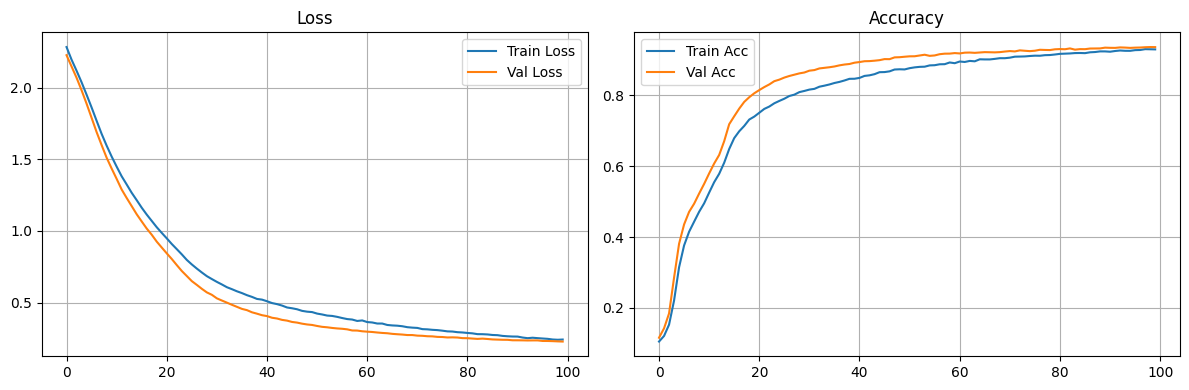

In [9]:

history = best_trainer.history

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"],   label="Val Loss")
plt.title("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"],   label="Val Acc")
plt.title("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()




Visualized the test (do change)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/var/folders/11/82r2_0991njg6n8j1xjz5kmw0000gn/T/ipykernel_35210/2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


🏆 Test Loss: 0.5114 | Test Accuracy: 0.8553


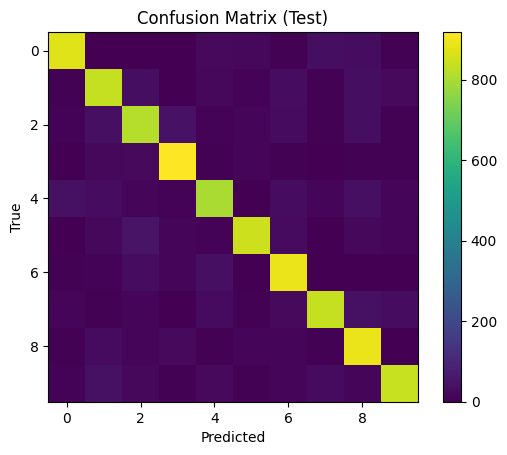

Classification report (Test):
              precision    recall  f1-score   support

           0     0.9055    0.8720    0.8884      1000
           1     0.8150    0.8370    0.8259      1000
           2     0.7979    0.8170    0.8073      1000
           3     0.8810    0.9180    0.8991      1000
           4     0.8311    0.8020    0.8163      1000
           5     0.9159    0.8490    0.8812      1000
           6     0.8352    0.8920    0.8627      1000
           7     0.8941    0.8360    0.8641      1000
           8     0.8011    0.8900    0.8432      1000
           9     0.8955    0.8400    0.8669      1000

    accuracy                         0.8553     10000
   macro avg     0.8572    0.8553    0.8555     10000
weighted avg     0.8572    0.8553    0.8555     10000



In [10]:
test_loss, test_acc = best_trainer.evaluate(test_loader)
print(f"🏆 Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

preds, targets = best_trainer.predict_all(test_loader)

cm = confusion_matrix(targets, preds)
plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

print("Classification report (Test):")
print(classification_report(targets, preds, digits=4))